<a href="https://colab.research.google.com/github/alvaro-salgado/PCD_MCD/blob/main/Tarea_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 7

In [1]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Tarea 8/data'

cat_data_path = '/content/drive/MyDrive/Tarea 8/data/cat'
dog_data_path = '/content/drive/MyDrive/Tarea 8/data/dog'

os.makedirs(cat_data_path, exist_ok=True)
os.makedirs(dog_data_path, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import librosa

def load_audio(file_path, sr=22050):
    # Cargar el archivo de audio
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def extract_mfcc_features(audio, sr=22050, n_mfcc=13, max_len=500):
    # Extraer características MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Si es necesario, rellenar con ceros para que todas las matrices tengan la misma longitud
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    return mfccs

def preprocess_audio(directory, label, max_files=10, max_len=500):
    data = []
    labels = []
    files = os.listdir(directory)[:max_files]  # Solo los primeros `max_files` archivos

    for file in files:
        file_path = os.path.join(directory, file)
        audio = load_audio(file_path)
        mfccs = extract_mfcc_features(audio, max_len=max_len)
        data.append(mfccs)
        labels.append(label)

    return np.array(data), np.array(labels)

In [12]:
# Ejemplo de uso para gatos y perros
cat_data, cat_labels = preprocess_audio(cat_data_path, 0, max_files=100)  # 0 para gatos
dog_data, dog_labels = preprocess_audio(dog_data_path, 1, max_files=100)  # 1 para perros

# Verificar que los datos y las etiquetas se cargaron correctamente
print(f'Número de muestras de gatos: {len(cat_data)}')
print(f'Número de etiquetas de gatos: {len(cat_labels)}')
print(f'Número de muestras de perros: {len(dog_data)}')
print(f'Número de etiquetas de perros: {len(dog_labels)}')

# Combinar datos y etiquetas
X = np.concatenate((cat_data, dog_data), axis=0)
y = np.concatenate((cat_labels, dog_labels), axis=0)

# Asegurarse de que los datos tengan la forma correcta para el modelo
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Verificar las formas de los datos y etiquetas
print(f'Forma de X: {X.shape}')
print(f'Forma de y: {y.shape}')

Número de muestras de gatos: 100
Número de etiquetas de gatos: 100
Número de muestras de perros: 100
Número de etiquetas de perros: 100
Forma de X: (200, 13, 500, 1)
Forma de y: (200,)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Construir el modelo de red neuronal profunda
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Ajustar hiperparámetros
epochs = 10  # Número de épocas
batch_size = 16  # Tamaño de lote

# Construir y entrenar el modelo con hiperparámetros ajustados
model = build_model(input_shape=(X.shape[1], X.shape[2], 1), num_classes=2)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4853 - loss: 44.3401 - val_accuracy: 0.7750 - val_loss: 2.9630
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8514 - loss: 2.2433 - val_accuracy: 0.7750 - val_loss: 1.1301
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8908 - loss: 0.4606 - val_accuracy: 0.8750 - val_loss: 0.4247
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9354 - loss: 0.1699 - val_accuracy: 0.8750 - val_loss: 0.3480
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9760 - loss: 0.0802 - val_accuracy: 0.9000 - val_loss: 0.3828
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9921 - loss: 0.0341 - val_accuracy: 0.9000 - val_loss: 0.3933
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9946 - loss: 0.0172 - val_accuracy: 0.9000 - val_loss: 0.3834
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9000 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9292 - loss: 0.4487
Test Accuracy: 0.93
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


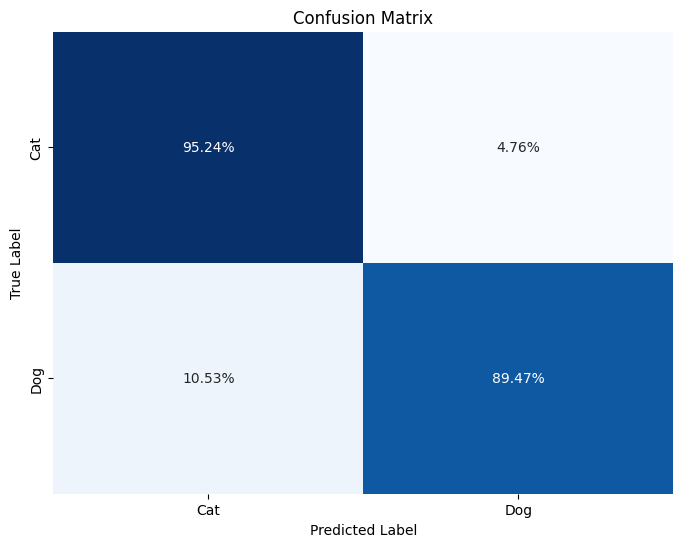

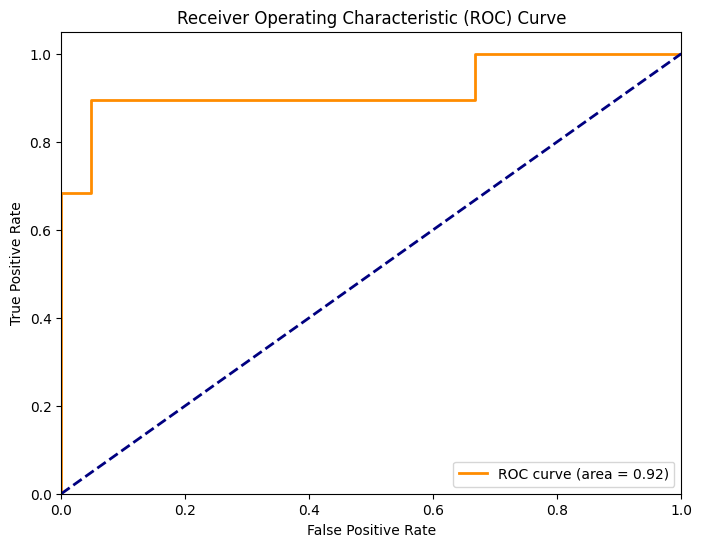

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

# Predecir etiquetas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=conf_matrix_percent, fmt=".2%", cmap='Blues', cbar=False, xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
conf_matrix

array([[20,  1],
       [ 2, 17]])